# Cartpole



The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the carptole upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}
\end{equation*}
$$

**Note**: To deal with angle wrap-around issues, we augment the state as follows:

$$
\begin{equation*}
\hat{\textbf{x}} = \begin{bmatrix}
    x & \dot{x} & \dot{\theta} & \sin{\theta} & \cos{\theta}
    \end{bmatrix}
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by instead fitting
for unconstrained actions and then applying it to a squashing function $\tanh(\textbf{u})$.
This is directly embedded into the dynamics model in order to be auto-differentiated.
This also means that we need to apply this transformation manually to the output of our
controller at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.05  # Time step (s).
CONSTRAIN = True  # Whether to constrain the action space or not.
RENDER = True  # Whether to render the environment or not.
MIN_BOUNDS = -1.0  # Minimum torque (N m).
MAX_BOUNDS = +1.0  # Maximum torque (N m).
N = 500 if CONSTRAIN else 100  # Horizon length.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.cartpole.CartpoleCost()
model = pddp.examples.cartpole.CartpoleDynamicsModel(DT)
env = pddp.examples.cartpole.CartpoleEnv(dt=DT, render=RENDER)

In [8]:
if CONSTRAIN:
    # Constrain the environment and model.
    pddp.utils.constraint.constrain_env(env, MIN_BOUNDS, MAX_BOUNDS)
    pddp.utils.constraint.constrain_model(model, MIN_BOUNDS, MAX_BOUNDS)

In [9]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
    X = pddp.utils.angular.reduce_state(Z, model.angular_indices,
                                        model.non_angular_indices)
    X = X.detach().numpy()
    if CONSTRAIN:
        U = pddp.utils.constraint.constrain(U, MIN_BOUNDS, MAX_BOUNDS)
    U = U.detach().numpy()

    x = X[:, 0]
    x_dot = X[:, 1]
    theta = np.unwrap(X[:, 2])  # Makes for smoother plots.
    theta_dot = X[:, 3]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position path")
    
    plt.figure()
    plt.plot(t, x_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m / s)")
    plt.title("Velocity path")
    
    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.title("Constrained action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [10]:
def on_iteration(iteration, Z, U, J_opt, accepted, converged):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    info = "CONVERGED" if converged else ("accepted" if accepted else "FAILED")
    final_state = pddp.utils.angular.reduce_state(Z[-1], model.angular_indices,
                                                  model.non_angular_indices).detach().numpy()
    print("iteration", iteration + 1, info, J_opt, final_state)

In [11]:
controller = pddp.controllers.PDDPController(env, model, cost)

In [12]:
U = torch.randn(N, model.action_size)

In [13]:
J_hist = []
controller.eval()
Z, U = controller.fit(U, encoding=ENCODING, n_iterations=100, on_iteration=on_iteration)

iteration 1 accepted 183424.39 [ 0.04795483 -0.24716428 -0.28279793 -1.064922  ]
iteration 2 accepted 183070.47 [-4.0193979e-04 -5.8814019e-02 -4.1092473e-01 -1.5000644e+00]
iteration 3 accepted 183034.94 [-0.04485583 -0.24612066 -0.40436867 -1.4279468 ]
iteration 4 accepted 182645.58 [-0.02139871 -0.06773774 -0.4719892  -1.661495  ]
iteration 5 accepted 182425.86 [-0.02691342 -0.21912566 -0.36092642 -1.3246303 ]
iteration 6 accepted 182187.44 [-0.00679449 -0.06324753 -0.48511034 -1.6945995 ]
iteration 7 accepted 181986.4 [-0.01042664 -0.19766124 -0.37474942 -1.3612868 ]
iteration 8 accepted 181816.02 [ 0.02852609 -0.03352109 -0.5224429  -1.7926061 ]
iteration 9 accepted 181564.31 [-0.00590574 -0.19520137 -0.38370502 -1.3839537 ]
iteration 10 accepted 181479.77 [ 0.02014334 -0.03935631 -0.5638118  -1.9010359 ]
iteration 11 accepted 181210.23 [-0.0113559  -0.1968223  -0.40863222 -1.4496045 ]
iteration 12 accepted 181081.5 [ 0.0186074  -0.04308781 -0.5665494  -1.905738  ]
iteration 13 ac

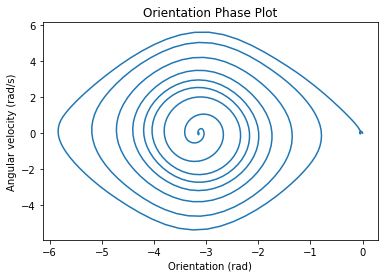

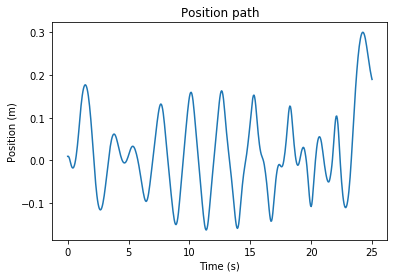

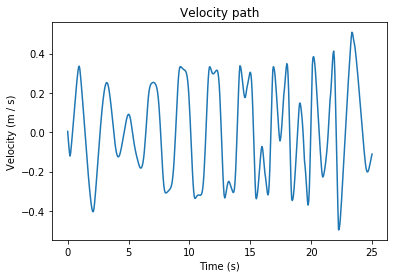

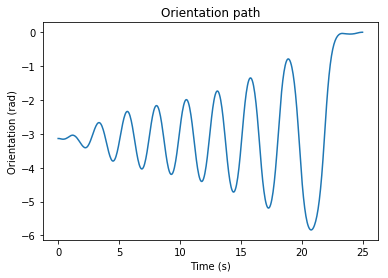

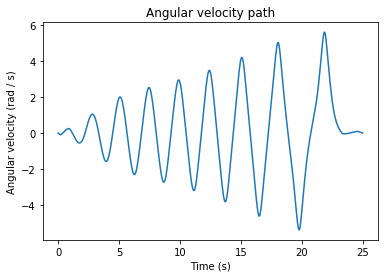

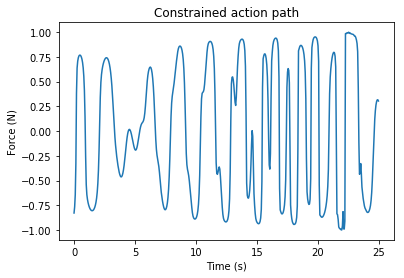

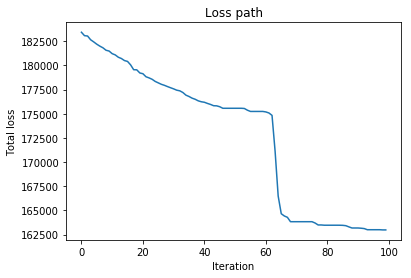

In [14]:
plot(Z, U)

In [15]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [16]:
import time

for u in U:
    env.apply(u)
    time.sleep(DT)

In [17]:
env.close()